In [1]:
import sys
import os

# Projektverzeichnis
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Füge dem sys.path hinzu, falls noch nicht vorhanden
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from models import *

# Utils
import src.utils.presenter as show
from src.utils.analize import check_constrains as check

# External
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [3]:
Job.clone_jobs(referenced_version="base", new_version="gt")

✅ 622 Jobs von Version 'base' nach Version 'gt' kopiert.


In [4]:
# Jobs
df_jobs_times = Job.get_dataframe(version="gt")
df_jobs_times = df_jobs_times[df_jobs_times.Arrival <= 60*24*1]
df_jobs_times

,Job,Routing_ID,Arrival,Ready Time,Deadline,Status,Version
0,J25-0000,8,77,1440,2760,open,gt
1,J25-0001,6,127,1440,2645,open,gt
2,J25-0002,0,194,1440,3800,open,gt
3,J25-0003,2,238,1440,4273,open,gt
4,J25-0004,3,280,1440,3284,open,gt
5,J25-0005,1,487,1440,3743,open,gt
6,J25-0006,9,773,1440,3260,open,gt
7,J25-0007,5,905,1440,3124,open,gt
8,J25-0008,4,967,1440,3593,open,gt
9,J25-0009,7,982,1440,3575,open,gt


In [5]:
# Routings
df_routings = RoutingOperation.get_dataframe()
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
...,...,...,...,...
95,9,5,M09,76
96,9,6,M05,47
97,9,7,M03,52
98,9,8,M04,90


In [6]:
def get_jssp_for_jobs(df_jobs_times, df_routings):
    """
    Erstellt ein JSSP-kompatibles DataFrame durch Verknüpfung von Job-Zeitdaten mit Routings.

    Parameter:
    - df_jobs_times: DataFrame mit mindestens den Spalten 'Job' und 'Routing_ID'.
    - df_routings: DataFrame mit Spalte 'Routing_ID' und den zugehörigen Operationsdaten.

    Rückgabe:
    - df_jssp: DataFrame mit allen für das JSSP notwendigen Informationen, inklusive 'Job' und den Operationen.
    """
    # 1. Relevante Spalten extrahieren
    df_job_ids = df_jobs_times[['Job', 'Routing_ID']].copy()

    # 2. Merge mit df_routings über Routing_ID
    df_jssp = df_job_ids.merge(df_routings, on='Routing_ID')

    return df_jssp

In [7]:
df_jssp = get_jssp_for_jobs(df_jobs_times, df_routings)
df_jssp

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
...,...,...,...,...,...
155,J25-0015,5,5,M09,72
156,J25-0015,5,6,M00,47
157,J25-0015,5,7,M06,65
158,J25-0015,5,8,M04,6


In [8]:
import pandas as pd
import random
from collections import defaultdict

def giffler_thompson_schedule(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    priority_rule: str = "SPT",
    log_on: bool = True
) -> pd.DataFrame:
    """
    Giffler-Thompson-Algorithmus mit Ready Time (für Planung) und Arrival (für Ausgabe).
    Rückgabe mit Lateness, Tardiness, Earliness.

    Rückgabe:
    - df_schedule: DataFrame mit Zeitplan und Auswertung
    - makespan: maximale Endzeit
    - total_abs_lateness: Summe der absoluten Lateness der letzten Operationen je Job
    """

    if log_on: 
        print(f'Giffler-Thompson-Algorithmus mit Prioritätsregel \"{priority_rule}\" gestartet ...\n')

    df = df_jssp.copy().sort_values(['Job', 'Operation']).reset_index(drop=True)
    machines = set(df['Machine'])
    jobs = df['Job'].unique()

    ready_time = df_arrivals_deadlines.set_index("Job")["Ready Time"].to_dict()
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()

    job_op_ready = {job: 0 for job in jobs}
    machine_available = {m: 0 for m in machines}
    job_op_index = {job: 0 for job in jobs}

    job_ops = defaultdict(list)
    for _, row in df.iterrows():
        job_ops[row['Job']].append((row['Operation'], row['Machine'], row['Processing Time']))

    result = []
    remaining = sum(len(v) for v in job_ops.values())

    while remaining > 0:
        candidates = []
        for job in jobs:
            idx = job_op_index[job]
            if idx < len(job_ops[job]):
                op_id, m, d = job_ops[job][idx]
                est = max(job_op_ready[job], machine_available[m], ready_time[job])
                candidates.append((est, d, job, op_id, m))

        min_est = min(c[0] for c in candidates)
        conflict_ops = [c for c in candidates if c[0] == min_est]

        if priority_rule == "SPT":
            selected = min(conflict_ops, key=lambda x: x[1])
        elif priority_rule == "EDF" or priority_rule == "EDD":
            selected = min(conflict_ops, key=lambda x: deadline[x[2]])  # x[2] ist der Job
        else:  # RANDOM oder unbekannt
            selected = random.choice(conflict_ops)

        est, d, job, op_id, m = selected
        start = est
        end = start + d

        result.append({
            'Job': job,
            'Operation': op_id,
            'Machine': m,
            'Start': start,
            'Processing Time': d,
            'End': end
        })

        job_op_ready[job] = end
        machine_available[m] = end
        job_op_index[job] += 1
        remaining -= 1

    # Berechnung von Lateness, Tardiness, Earliness
    for row in result:
        job = row['Job']
        lateness_val = row['End'] - deadline[job]
        row.update({
            "Arrival": arrival[job],
            "Deadline": deadline[job],
            "Lateness": lateness_val,
            "Tardiness": max(0, lateness_val),
            "Earliness": max(0, -lateness_val)
        })

    df_schedule = pd.DataFrame(result).sort_values(['Start', 'Job', 'Operation']).reset_index(drop=True)

    last_ops = df_schedule.groupby("Job")["Operation"].max()
    last_op_index_tuples = list(zip(last_ops.index, last_ops.values))
    mask_last_ops = df_schedule.set_index(["Job", "Operation"]).index.isin(last_op_index_tuples)
    total_abs_lateness = df_schedule[mask_last_ops]["Lateness"].abs().sum()

    ende = df_schedule['End'].max()

    if log_on:
        print("\nPlan-Informationen:")
        print(f"  Anzahl Jobs            : {len(jobs)}")
        print(f"  Anzahl Maschinen       : {len(machines)}")
        print(f"  Anzahl Operationen     : {len(df_schedule)}")
        print(f"  Ende                   : {ende}")
        print(f"  Summe Absolute Lateness: {total_abs_lateness}")

    return df_schedule


### SPT

In [9]:
df_schedule = giffler_thompson_schedule(
    df_jssp=df_jssp,
    df_arrivals_deadlines=df_jobs_times,
    priority_rule="SPT",
    log_on=True
)

last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Tardiness", max_val = 840, steps= 120)

Giffler-Thompson-Algorithmus mit Prioritätsregel "SPT" gestartet ...


Plan-Informationen:
  Anzahl Jobs            : 16
  Anzahl Maschinen       : 10
  Anzahl Operationen     : 160
  Ende                   : 2979
  Summe Absolute Lateness: 18961


label
0            16
0 - 120       0
120 - 240     0
240 - 360     0
360 - 480     0
480 - 600     0
600 - 720     0
720 - 840     0
>840          0
Name: count, dtype: int64

### EDD (EDF)

In [10]:
df_schedule = giffler_thompson_schedule(
    df_jssp=df_jssp,
    df_arrivals_deadlines=df_jobs_times,
    priority_rule="EDF",
    log_on=True
)

df_schedule

Giffler-Thompson-Algorithmus mit Prioritätsregel "EDF" gestartet ...


Plan-Informationen:
  Anzahl Jobs            : 16
  Anzahl Maschinen       : 10
  Anzahl Operationen     : 160
  Ende                   : 3124
  Summe Absolute Lateness: 16341


,Job,Operation,Machine,Start,Processing Time,End,Arrival,Deadline,Lateness,Tardiness,Earliness
0,J25-0000,0,M00,1440,76,1516,77,2760,-1244,0,1244
1,J25-0001,0,M01,1440,46,1486,127,2645,-1159,0,1159
2,J25-0007,0,M02,1440,84,1524,905,3124,-1600,0,1600
3,J25-0006,0,M01,1486,85,1571,773,3260,-1689,0,1689
4,J25-0001,1,M00,1516,37,1553,127,2645,-1092,0,1092
...,...,...,...,...,...,...,...,...,...,...,...
155,J25-0012,8,M09,2968,45,3013,1079,5140,-2127,0,2127
156,J25-0014,9,M06,2968,53,3021,1196,3966,-945,0,945
157,J25-0012,9,M04,3013,33,3046,1079,5140,-2094,0,2094
158,J25-0013,8,M09,3059,22,3081,1166,5546,-2465,0,2465


In [11]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Tardiness", max_val = 840, steps= 120)

label
0            16
0 - 120       0
120 - 240     0
240 - 360     0
360 - 480     0
480 - 600     0
600 - 720     0
720 - 840     0
>840          0
Name: count, dtype: int64

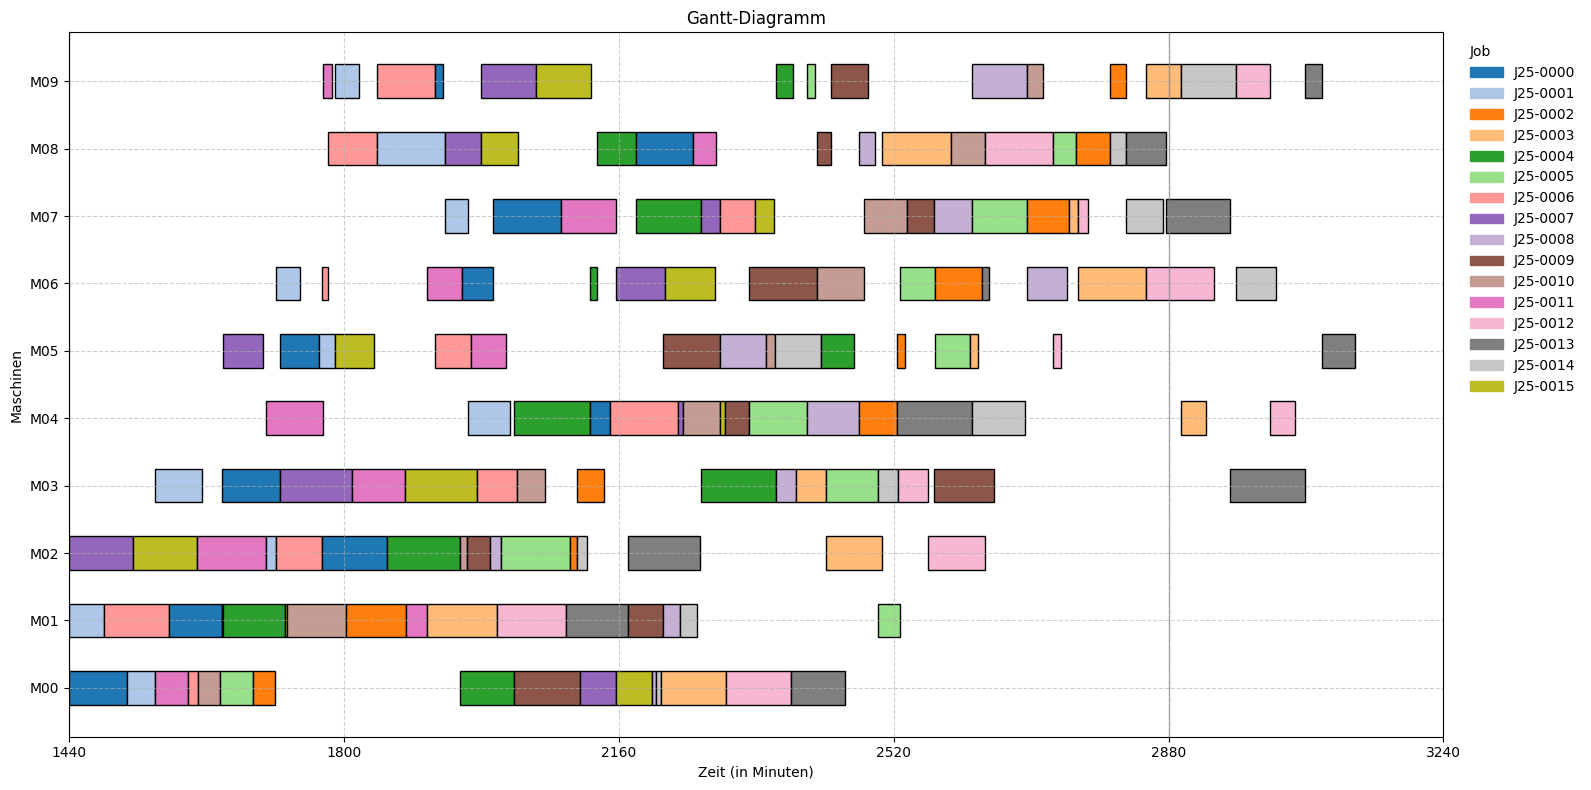

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [12]:
show.plot_gantt(df_schedule, perspective="Machine")

check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

In [15]:
import pandas as pd
from collections import defaultdict

def extended_giffler_thompson(jobs_data, job_ready_times):
    schedule = {}  # {operation_id: (start_time, end_time)}
    available_time = defaultdict(int)
    machine_state = defaultdict(lambda: None)

    A = []  # aktive, planbare Operationen
    for job_id, operations in jobs_data.items():
        A.append(operations[0])  # erste Operation freigeben

    S = set()  # geplante Operationen

    def ready_time(op):
        preds = op['predecessors']
        if not preds:
            return job_ready_times[op['id'][0]]  # Ready Time aus df_jobs_times
        return max(schedule[pred][1] for pred in preds)

    while A:
        ES = {}
        for op in A:
            m = op['machine']
            p = op['duration']
            rt = ready_time(op)
            ES[op['id']] = max(rt, available_time[m])

        # Operation mit frühestem Endzeitpunkt
        O_star = min(A, key=lambda op: ES[op['id']] + op['duration'])
        m_star = O_star['machine']
        end_star = ES[O_star['id']] + O_star['duration']

        # Konfliktmenge
        C = [op for op in A if op['machine'] == m_star and ES[op['id']] < end_star]

        # Auswahlregel (SPT)
        O_hat = min(C, key=lambda op: op['duration'])

        # Einplanen
        op_id = O_hat['id']
        start = ES[op_id]
        end = start + O_hat['duration']
        schedule[op_id] = (start, end)
        available_time[m_star] = end
        S.add(op_id)
        A.remove(O_hat)

        # Nachfolger freigeben
        job_ops = jobs_data[op_id[0]]
        next_index = op_id[1] + 1
        if next_index < len(job_ops):
            successor = job_ops[next_index]
            if all(pred in S for pred in successor['predecessors']):
                A.append(successor)

    return schedule


def run_extended_gt_from_dataframe(df, df_jobs_times):
    """
    Erwartet:
    - df: DataFrame mit ["Job", "Routing_ID", "Operation", "Machine", "Processing Time"]
    - df_jobs_times: DataFrame mit ["Job", "Routing_ID", "Ready Time"]
    
    Gibt: Schedule als DataFrame mit ["Job", "Routing_ID", "Operation", "Machine", "Start", "End", "Processing Time"]
    """
    jobs_data = defaultdict(list)

    # Ready Times extrahieren
    job_ready_times = dict(zip(df_jobs_times["Job"], df_jobs_times["Ready Time"]))

    # Sortieren und strukturieren
    df_sorted = df.sort_values(by=["Job", "Operation"])
    for _, row in df_sorted.iterrows():
        job = row["Job"]
        op_idx = row["Operation"]
        op_id = (job, op_idx)
        machine = row["Machine"]
        duration = row["Processing Time"]
        operation = {
            "id": op_id,
            "machine": machine,
            "duration": duration,
            "predecessors": []
        }
        jobs_data[job].append(operation)

    # Predecessors setzen
    for job, ops in jobs_data.items():
        for i in range(1, len(ops)):
            ops[i]["predecessors"].append(ops[i-1]["id"])

    # Algorithmus anwenden
    schedule_dict = extended_giffler_thompson(jobs_data, job_ready_times)

    # Ergebnis zusammenbauen
    results = []
    for op_id, (start, end) in schedule_dict.items():
        job, op_idx = op_id
        row = df[(df["Job"] == job) & (df["Operation"] == op_idx)].iloc[0]
        results.append({
            "Job": job,
            "Routing_ID": row["Routing_ID"],
            "Operation": op_idx,
            "Machine": row["Machine"],
            "Processing Time": row["Processing Time"],
            "Start": start,
            "End": end
        })

    return pd.DataFrame(results)



df_schedule = run_extended_gt_from_dataframe(df_jssp, df_jobs_times)

In [16]:
df_schedule

,Job,Routing_ID,Operation,Machine,Processing Time,Start,End
0,J25-0008,4,0,M02,14,1440,1454
1,J25-0008,4,1,M00,6,1454,1460
2,J25-0014,4,0,M02,14,1454,1468
3,J25-0014,4,1,M00,6,1468,1474
4,J25-0008,4,2,M01,22,1460,1482
...,...,...,...,...,...,...,...
155,J25-0012,2,8,M09,45,3078,3123
156,J25-0012,2,9,M04,33,3123,3156
157,J25-0013,3,7,M03,98,3113,3211
158,J25-0013,3,8,M09,22,3211,3233


In [ ]:
import pandas as pd
from collections import defaultdict

def extended_giffler_thompson(jobs_data, job_ready_times, prev_starts=None):
    schedule = {}  # {operation_id: (start_time, end_time)}
    available_time = defaultdict(int)
    machine_state = defaultdict(lambda: None)

    A = []
    for job_id, operations in jobs_data.items():
        A.append(operations[0])

    S = set()

    def ready_time(op):
        preds = op['predecessors']
        if not preds:
            return job_ready_times[op['id'][0]]
        return max(schedule[pred][1] for pred in preds)

    while A:
        ES = {}
        for op in A:
            m = op['machine']
            p = op['duration']
            rt = ready_time(op)
            ES[op['id']] = max(rt, available_time[m])

        O_star = min(A, key=lambda op: ES[op['id']] + op['duration'])
        m_star = O_star['machine']
        end_star = ES[O_star['id']] + O_star['duration']

        # Konfliktmenge
        C = [op for op in A if op['machine'] == m_star and ES[op['id']] < end_star]

        # Prioritätsregel mit Minimalabweichung vom alten Plan
        def priority(op):
            op_id = op['id']
            new_start = ES[op_id]
            if prev_starts and op_id in prev_starts:
                return abs(new_start - prev_starts[op_id])
            else:
                return float('inf')  # keine bevorzugung

        O_hat = min(C, key=priority)

        # Einplanen
        op_id = O_hat['id']
        start = ES[op_id]
        end = start + O_hat['duration']
        schedule[op_id] = (start, end)
        available_time[m_star] = end
        S.add(op_id)
        A.remove(O_hat)

        # Nachfolger freigeben
        job_ops = jobs_data[op_id[0]]
        next_index = op_id[1] + 1
        if next_index < len(job_ops):
            successor = job_ops[next_index]
            if all(pred in S for pred in successor['predecessors']):
                A.append(successor)

    return schedule


def run_extended_gt_from_dataframe(df, df_jobs_times, df_schedule_prev=None):
    """
    Erwartet:
    - df: DataFrame mit ["Job", "Routing_ID", "Operation", "Machine", "Processing Time"]
    - df_jobs_times: DataFrame mit ["Job", "Routing_ID", "Ready Time"]
    - df_schedule_prev: Optional, DataFrame mit ["Job", "Operation", "Start"] (zuvor geplante Starts)
    
    Gibt: DataFrame mit ["Job", "Routing_ID", "Operation", "Machine", "Processing Time", "Start", "End"]
    """

    jobs_data = defaultdict(list)
    job_ready_times = dict(zip(df_jobs_times["Job"], df_jobs_times["Ready Time"]))

    # Optional: vorherige Startzeiten vorbereiten
    prev_starts = None
    if df_schedule_prev is not None:
        prev_starts = {
            (row["Job"], row["Operation"]): row["Start"]
            for _, row in df_schedule_prev.iterrows()
        }

    # Operationen einlesen
    df_sorted = df.sort_values(by=["Job", "Operation"])
    for _, row in df_sorted.iterrows():
        job = row["Job"]
        op_idx = row["Operation"]
        op_id = (job, op_idx)
        machine = row["Machine"]
        duration = row["Processing Time"]
        operation = {
            "id": op_id,
            "machine": machine,
            "duration": duration,
            "predecessors": []
        }
        jobs_data[job].append(operation)

    for job, ops in jobs_data.items():
        for i in range(1, len(ops)):
            ops[i]["predecessors"].append(ops[i-1]["id"])

    # Algorithmus anwenden
    schedule_dict = extended_giffler_thompson(jobs_data, job_ready_times, prev_starts)

    # Ergebnis als DataFrame
    results = []
    for op_id, (start, end) in schedule_dict.items():
        job, op_idx = op_id
        row = df[(df["Job"] == job) & (df["Operation"] == op_idx)].iloc[0]
        results.append({
            "Job": job,
            "Routing_ID": row["Routing_ID"],
            "Operation": op_idx,
            "Machine": row["Machine"],
            "Processing Time": row["Processing Time"],
            "Start": start,
            "End": end
        })

    return pd.DataFrame(results)
